In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.fc(z)
        return z.view(z.size(0), 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [5]:
def train(generator, discriminator, data_loader, device, num_epochs=5):
    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(data_loader):
            batch_size = imgs.size(0)
            real_imgs = imgs.to(device) 
            labels_real = torch.ones(batch_size, 1).to(device)  
            labels_fake = torch.zeros(batch_size, 1).to(device) 

            d_optimizer.zero_grad()
            output = discriminator(real_imgs)
            d_loss_real = criterion(output, labels_real)
            d_loss_real.backward()

            z = torch.randn(batch_size, 100).to(device)
            fake_imgs = generator(z)
            output = discriminator(fake_imgs.detach())
            d_loss_fake = criterion(output, labels_fake)
            d_loss_fake.backward()
            d_optimizer.step()

            # Train generator
            g_optimizer.zero_grad()
            output = discriminator(fake_imgs)
            g_loss = criterion(output, labels_real)
            g_loss.backward()
            g_optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss_real.item() + d_loss_fake.item()}, G Loss: {g_loss.item()}")
        
        if (epoch + 1) % 10 == 0:
            plot_generated_images(generator, epoch, device)

def plot_generated_images(generator, epoch, device):
    z = torch.randn(64, 100).to(device) 
    generated_imgs = generator(z)
    generated_imgs = generated_imgs.detach().cpu().numpy() 
    generated_imgs = generated_imgs.reshape(64, 28, 28) 


    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(generated_imgs[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Generated Images - Epoch {epoch+1}')
    plt.show()

In [6]:
generator = Generator()
discriminator = Discriminator()

In [7]:
device = torch.device("cuda")
generator.to(device)
discriminator.to(device)

Discriminator(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Epoch [1/50], D Loss: 0.9277341403067112, G Loss: 7.719951629638672
Epoch [2/50], D Loss: 0.09386212006211281, G Loss: 3.939937114715576
Epoch [3/50], D Loss: 0.310573423281312, G Loss: 3.596379280090332
Epoch [4/50], D Loss: 0.5844849199056625, G Loss: 3.6774613857269287
Epoch [5/50], D Loss: 0.4076896235346794, G Loss: 1.9930205345153809
Epoch [6/50], D Loss: 0.5261963307857513, G Loss: 2.145209789276123
Epoch [7/50], D Loss: 0.55011186003685, G Loss: 2.307711362838745
Epoch [8/50], D Loss: 0.9331892728805542, G Loss: 1.5093905925750732
Epoch [9/50], D Loss: 0.7069918811321259, G Loss: 1.8339452743530273
Epoch [10/50], D Loss: 0.7814520299434662, G Loss: 1.9046497344970703


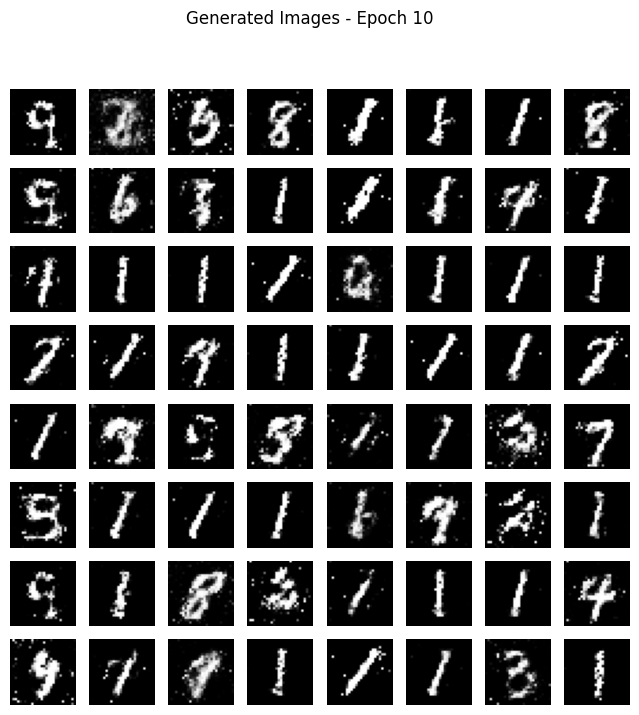

Epoch [11/50], D Loss: 0.5443539917469025, G Loss: 2.3867454528808594
Epoch [12/50], D Loss: 0.6917445659637451, G Loss: 2.377044916152954
Epoch [13/50], D Loss: 0.7832933664321899, G Loss: 2.7961323261260986
Epoch [14/50], D Loss: 0.8440266847610474, G Loss: 2.604123115539551
Epoch [15/50], D Loss: 0.6389252543449402, G Loss: 1.5120642185211182
Epoch [16/50], D Loss: 0.7629419565200806, G Loss: 1.59011709690094
Epoch [17/50], D Loss: 0.9142213463783264, G Loss: 1.938364028930664
Epoch [18/50], D Loss: 1.033704400062561, G Loss: 1.4607285261154175
Epoch [19/50], D Loss: 0.706510066986084, G Loss: 1.8073859214782715
Epoch [20/50], D Loss: 0.6442704498767853, G Loss: 2.5759224891662598


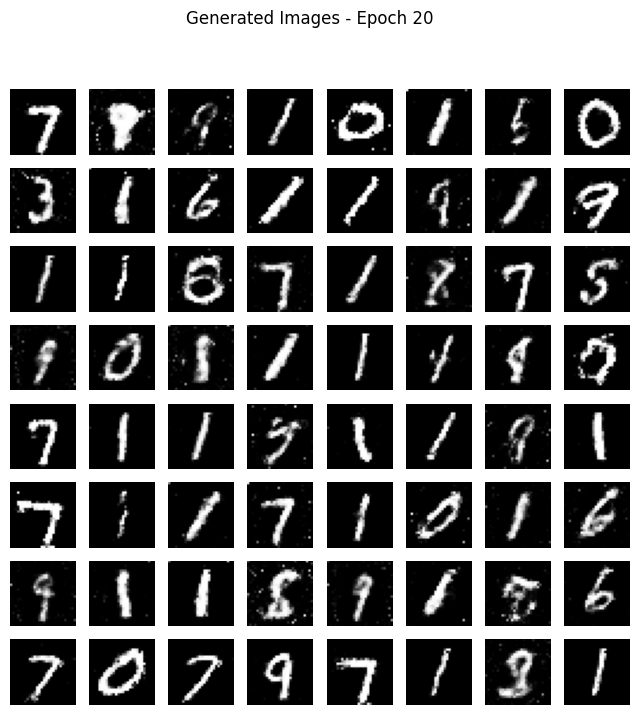

Epoch [21/50], D Loss: 0.799627423286438, G Loss: 1.7011373043060303
Epoch [22/50], D Loss: 1.1476137042045593, G Loss: 1.7986938953399658
Epoch [23/50], D Loss: 0.8587425947189331, G Loss: 1.5166301727294922
Epoch [24/50], D Loss: 0.935947835445404, G Loss: 1.409564733505249
Epoch [25/50], D Loss: 0.8942882120609283, G Loss: 1.7320348024368286
Epoch [26/50], D Loss: 0.9448143839836121, G Loss: 1.456524133682251
Epoch [27/50], D Loss: 0.7256110906600952, G Loss: 1.64914870262146
Epoch [28/50], D Loss: 0.8565149307250977, G Loss: 1.347491979598999
Epoch [29/50], D Loss: 0.77921262383461, G Loss: 1.9886468648910522
Epoch [30/50], D Loss: 0.7546496987342834, G Loss: 1.4721367359161377


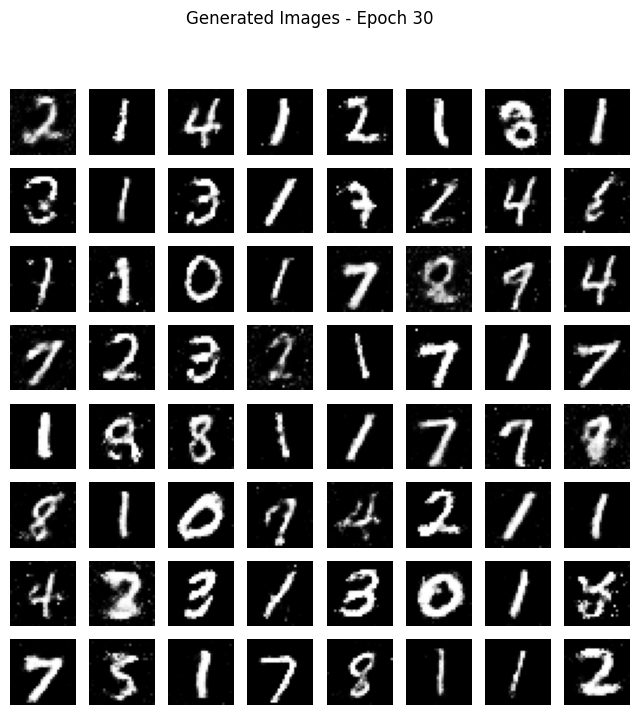

Epoch [31/50], D Loss: 1.0934506356716156, G Loss: 1.497009038925171
Epoch [32/50], D Loss: 1.0325710475444794, G Loss: 2.3105690479278564
Epoch [33/50], D Loss: 0.6701551973819733, G Loss: 1.8749200105667114
Epoch [34/50], D Loss: 0.8182559311389923, G Loss: 1.6501727104187012
Epoch [35/50], D Loss: 0.72370445728302, G Loss: 1.748104453086853
Epoch [36/50], D Loss: 0.6811464428901672, G Loss: 1.635850429534912
Epoch [37/50], D Loss: 0.8286593854427338, G Loss: 1.8747109174728394
Epoch [38/50], D Loss: 1.0165507197380066, G Loss: 1.407062292098999
Epoch [39/50], D Loss: 0.8242254853248596, G Loss: 1.5630217790603638
Epoch [40/50], D Loss: 0.8954229950904846, G Loss: 2.329728603363037


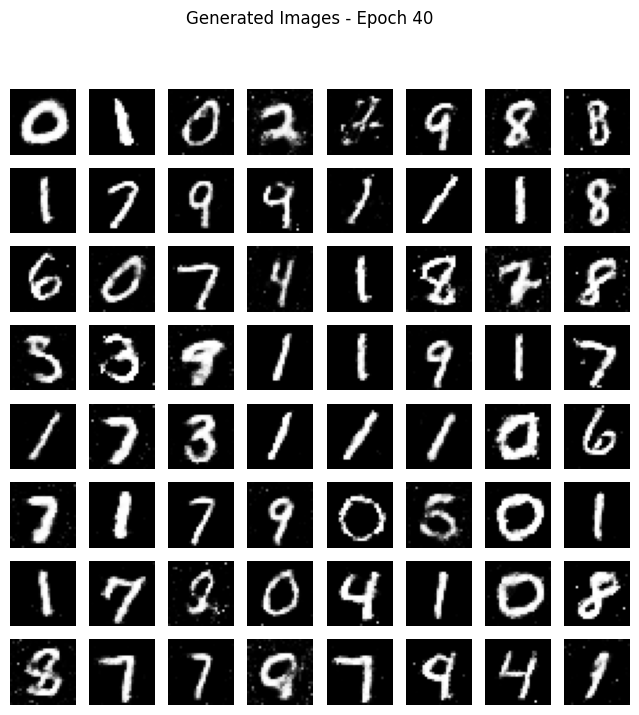

Epoch [41/50], D Loss: 0.8064817190170288, G Loss: 1.5728015899658203
Epoch [42/50], D Loss: 0.8785846531391144, G Loss: 1.9448808431625366
Epoch [43/50], D Loss: 0.7614676356315613, G Loss: 1.8172340393066406
Epoch [44/50], D Loss: 0.932039737701416, G Loss: 1.713998794555664
Epoch [45/50], D Loss: 1.0690203309059143, G Loss: 1.7314345836639404
Epoch [46/50], D Loss: 1.0414175689220428, G Loss: 1.7460755109786987
Epoch [47/50], D Loss: 0.7422640025615692, G Loss: 1.9068607091903687
Epoch [48/50], D Loss: 0.6966229379177094, G Loss: 1.9879685640335083
Epoch [49/50], D Loss: 0.8861070871353149, G Loss: 2.010307788848877
Epoch [50/50], D Loss: 0.8900033235549927, G Loss: 1.3815803527832031


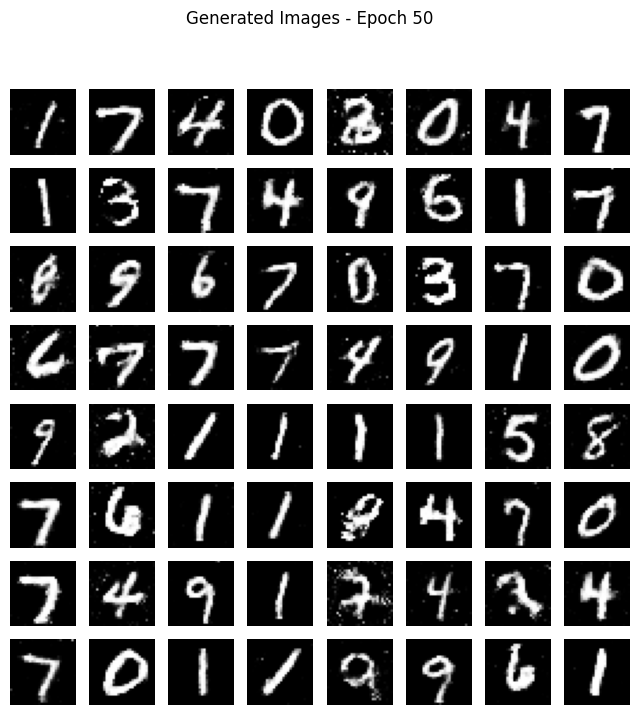

In [8]:
train(generator, discriminator, train_loader, device, num_epochs=50)